In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use(['science','ieee', 'no-latex']) # set the style of the plots

from util import *

# Neural Network

In [2]:
MLP = pd.read_pickle('data/MLP_results.pkl')
MLP['cvResults'] = MLP['cvResults'].transform(pd.DataFrame)
MLP

,numCat,nDims,testMetrics,cvResults,searchObj
0,3,27,"{'accuracy': 0.7856397027209631, 'precision': ...",mean_fit_time std_fit_time mean_score_tim...,"GridSearchCV(cv=4, estimator=MLPClassifier(max..."
1,5,41,"{'accuracy': 0.7816473189607518, 'precision': ...",mean_fit_time std_fit_time mean_score_tim...,"GridSearchCV(cv=4, estimator=MLPClassifier(max..."
2,10,63,"{'accuracy': 0.7988452797739697, 'precision': ...",mean_fit_time std_fit_time mean_score_tim...,"GridSearchCV(cv=4, estimator=MLPClassifier(max..."
3,20,84,"{'accuracy': 0.8068300472943922, 'precision': ...",mean_fit_time std_fit_time mean_score_tim...,"GridSearchCV(cv=4, estimator=MLPClassifier(max..."
4,42,105,"{'accuracy': 0.7990295436398256, 'precision': ...",mean_fit_time std_fit_time mean_score_tim...,"GridSearchCV(cv=4, estimator=MLPClassifier(max..."


In [3]:
metrics = MLP.testMetrics.iloc[0].keys() # get the metrics

for metric in metrics:
    MLP['bestTest'+metric.capitalize()] = [d[metric] for d in MLP.testMetrics]
MLP.drop(columns=['testMetrics'], inplace=True)

MLP['bestParams'] = MLP['searchObj'].transform(lambda x: x.best_params_)
params = MLP.bestParams.iloc[0].keys()

for param in params:
    MLP['best'+param.capitalize()] = [d[param] for d in MLP.bestParams]
MLP.drop(columns=['bestParams', 'cvResults', 'searchObj'], inplace=True)
MLP = MLP.drop(columns=['bestActivation', 'bestLearning_rate', 'bestSolver'])
MLP

,numCat,nDims,bestTestAccuracy,bestTestPrecision,bestTestRecall,bestTestF1,bestTestRoc_auc,bestAlpha,bestHidden_layer_sizes
0,3,27,0.785640,0.528831,0.848934,0.651697,0.888233,0.05,"(100,)"
1,5,41,0.781647,0.523143,0.855174,0.649166,0.893848,0.05,"(100,)"
2,10,63,0.798845,0.547879,0.849454,0.666123,0.901556,0.05,"(100,)"
3,20,84,0.806830,0.559782,0.853354,0.676074,0.904078,0.05,"(100,)"
4,42,105,0.799030,0.547674,0.857254,0.668356,0.903271,0.05,"(100,)"


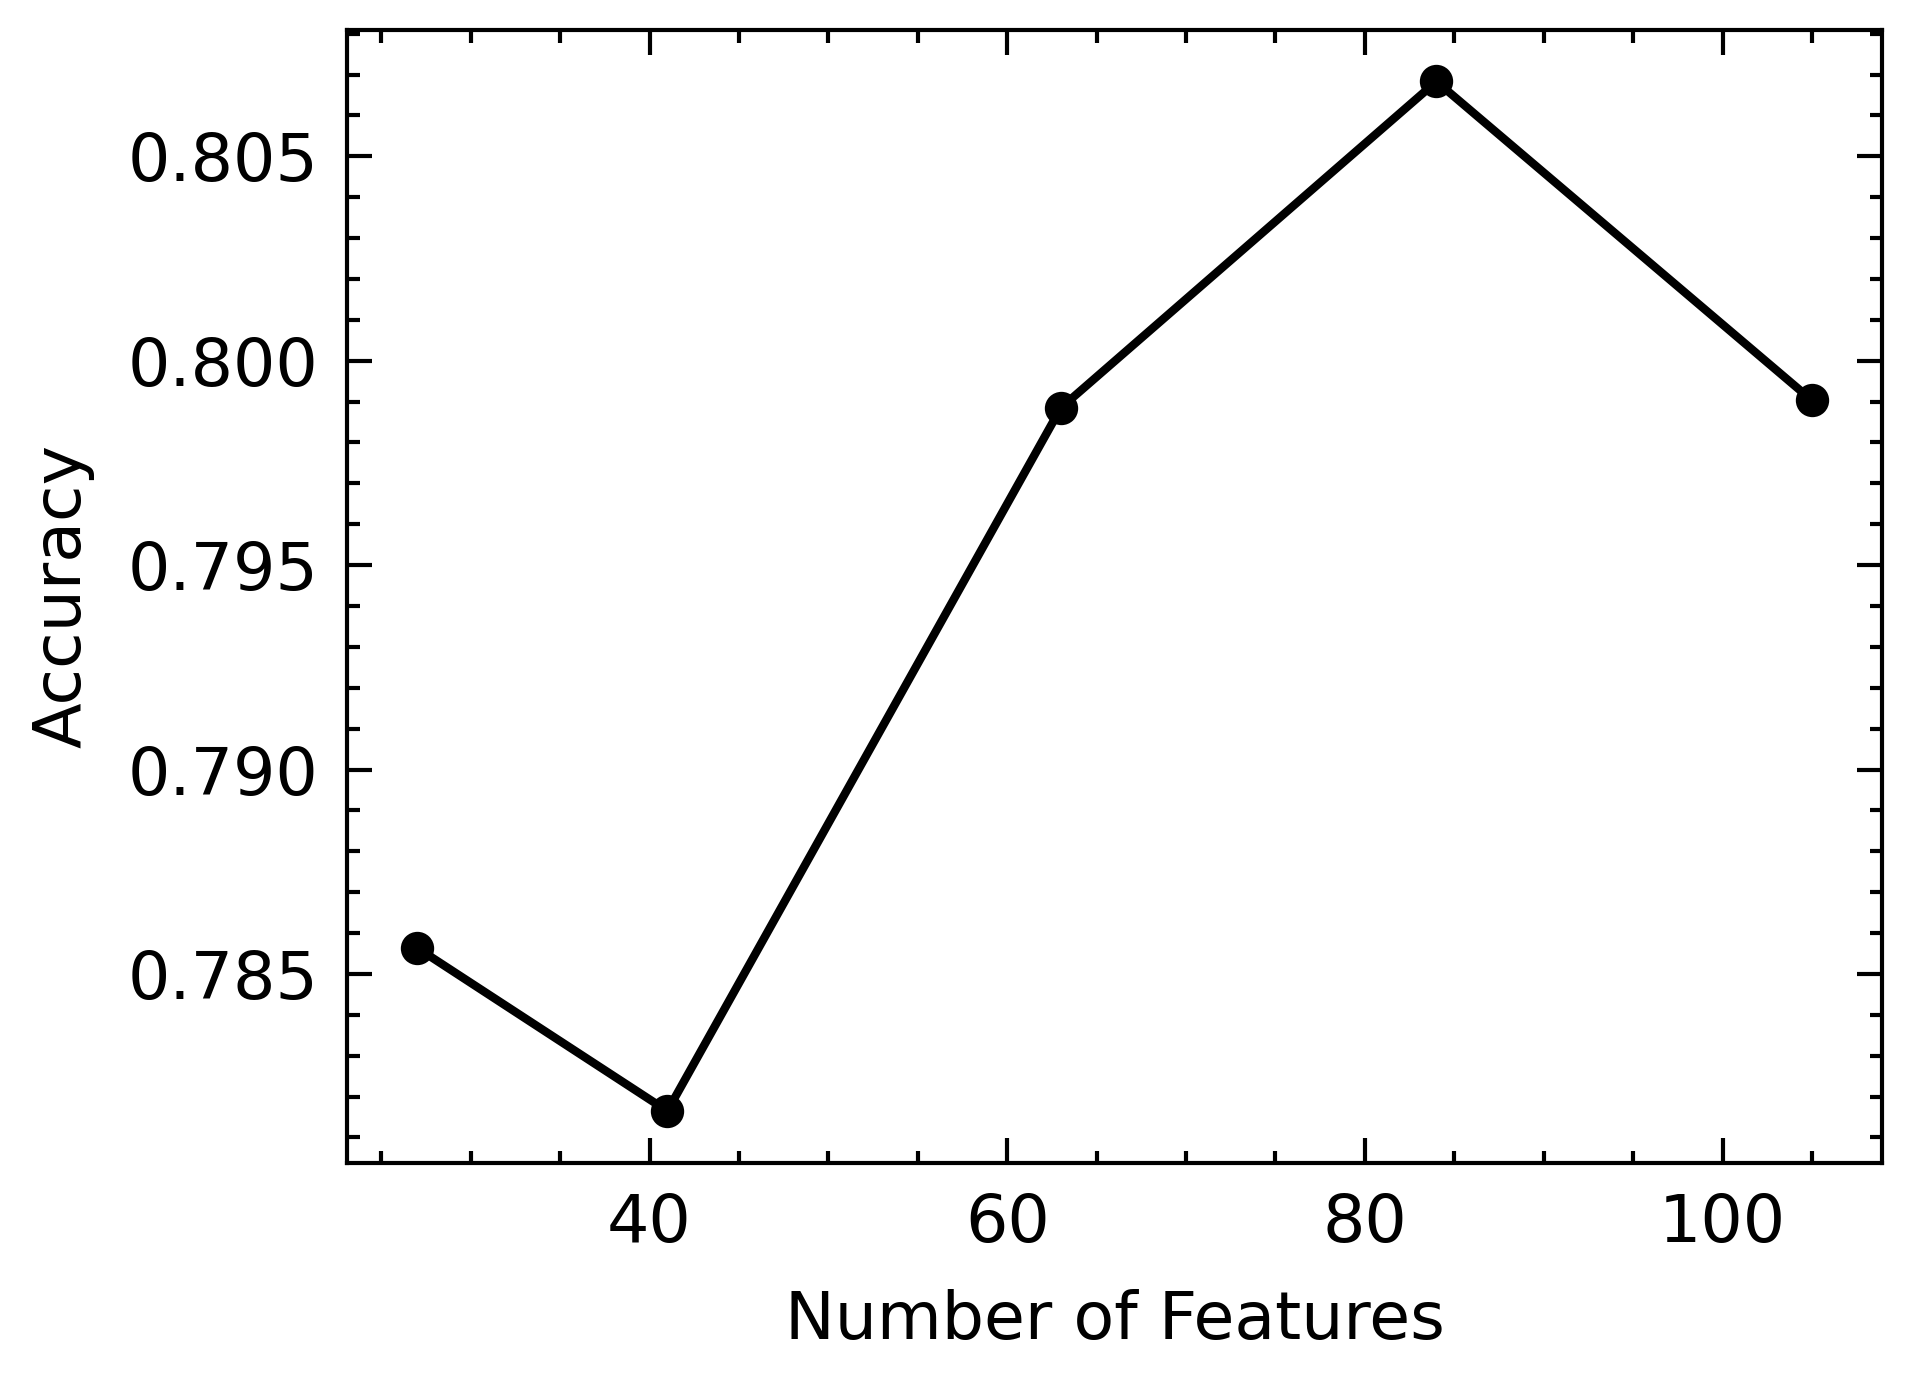

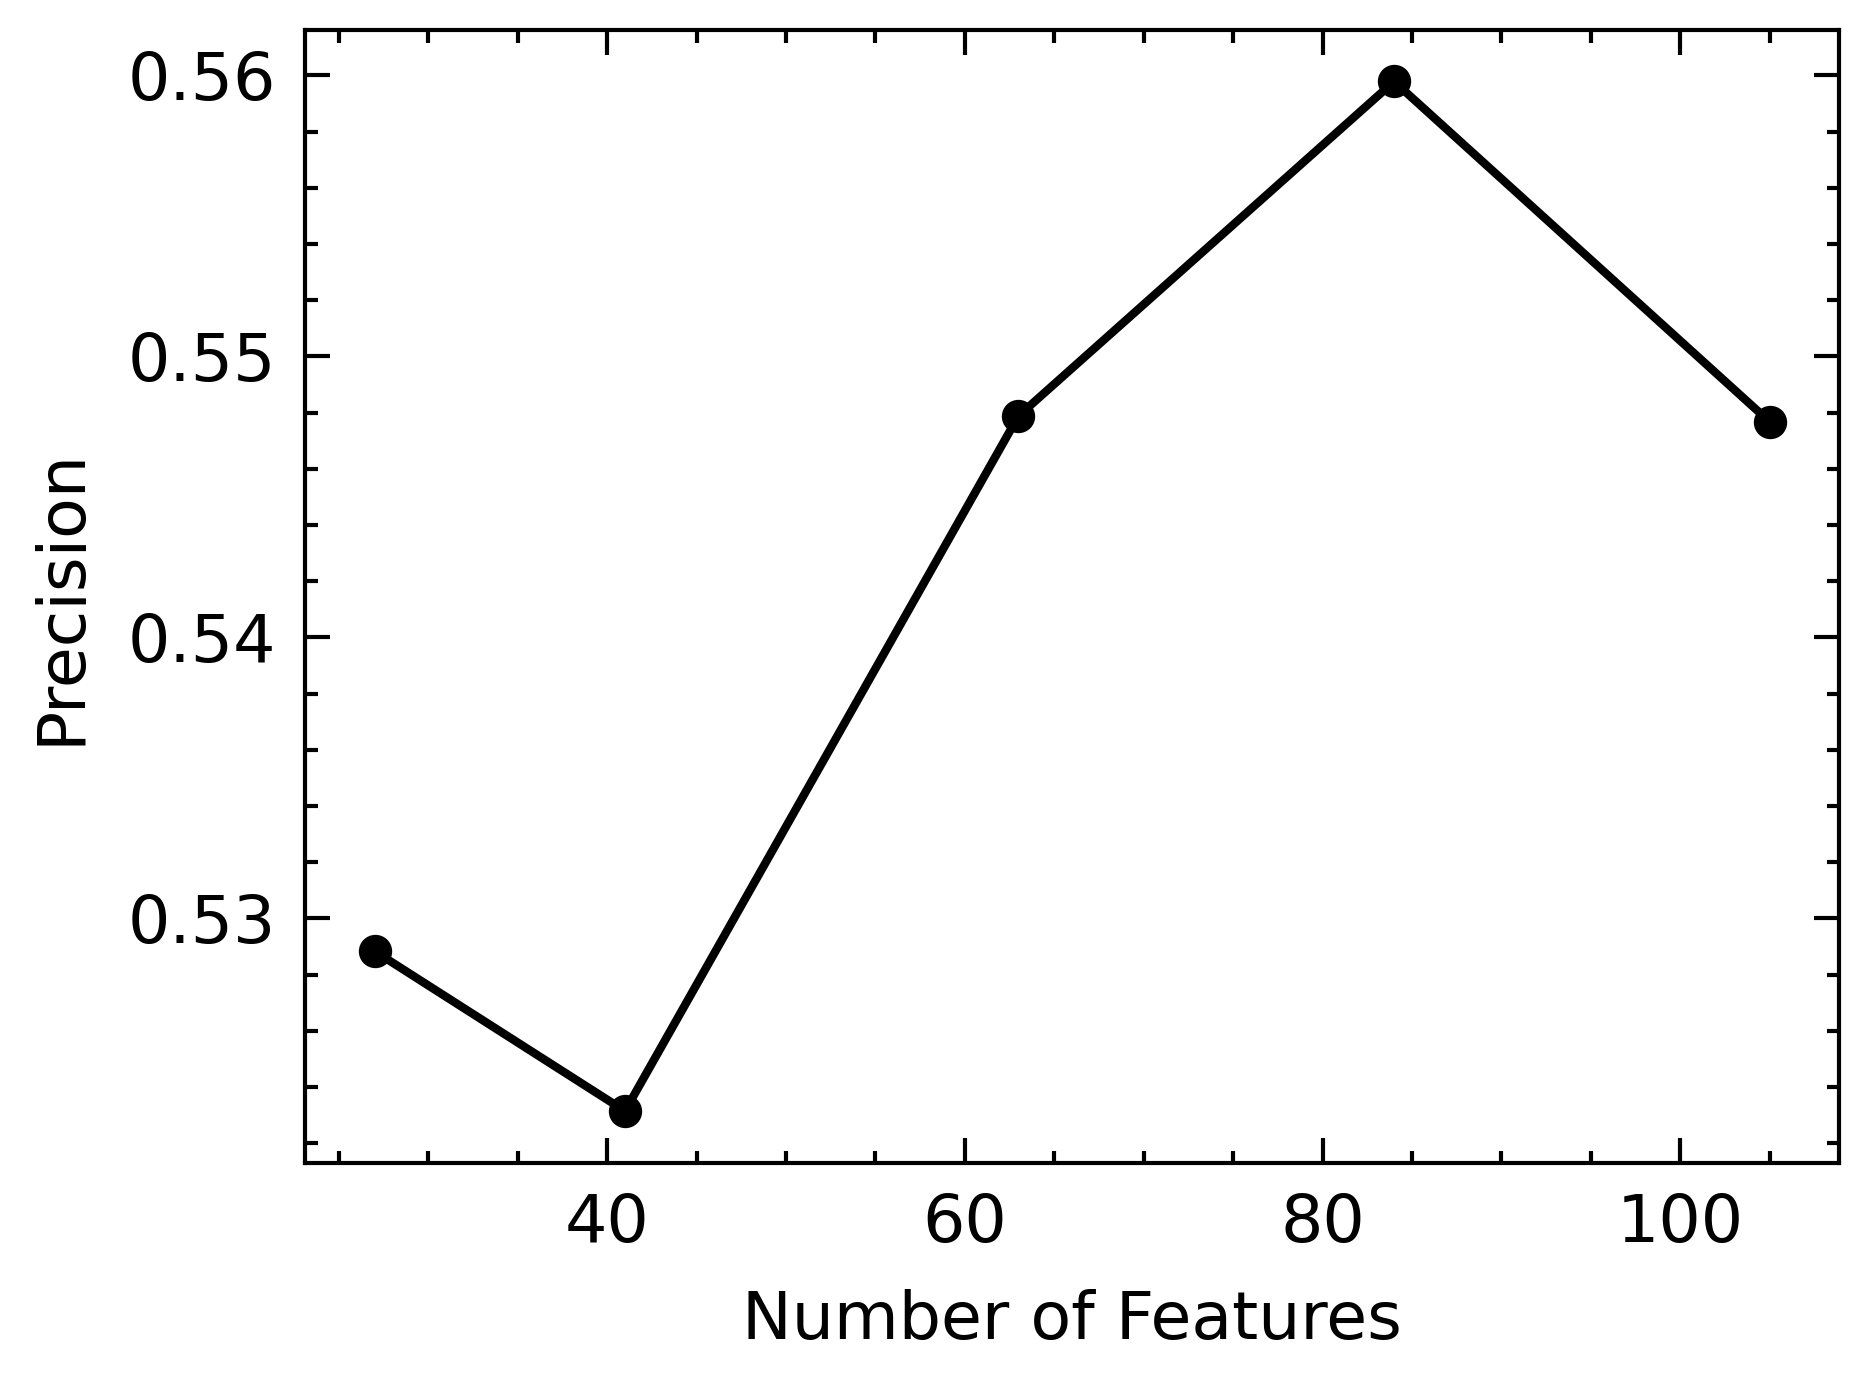

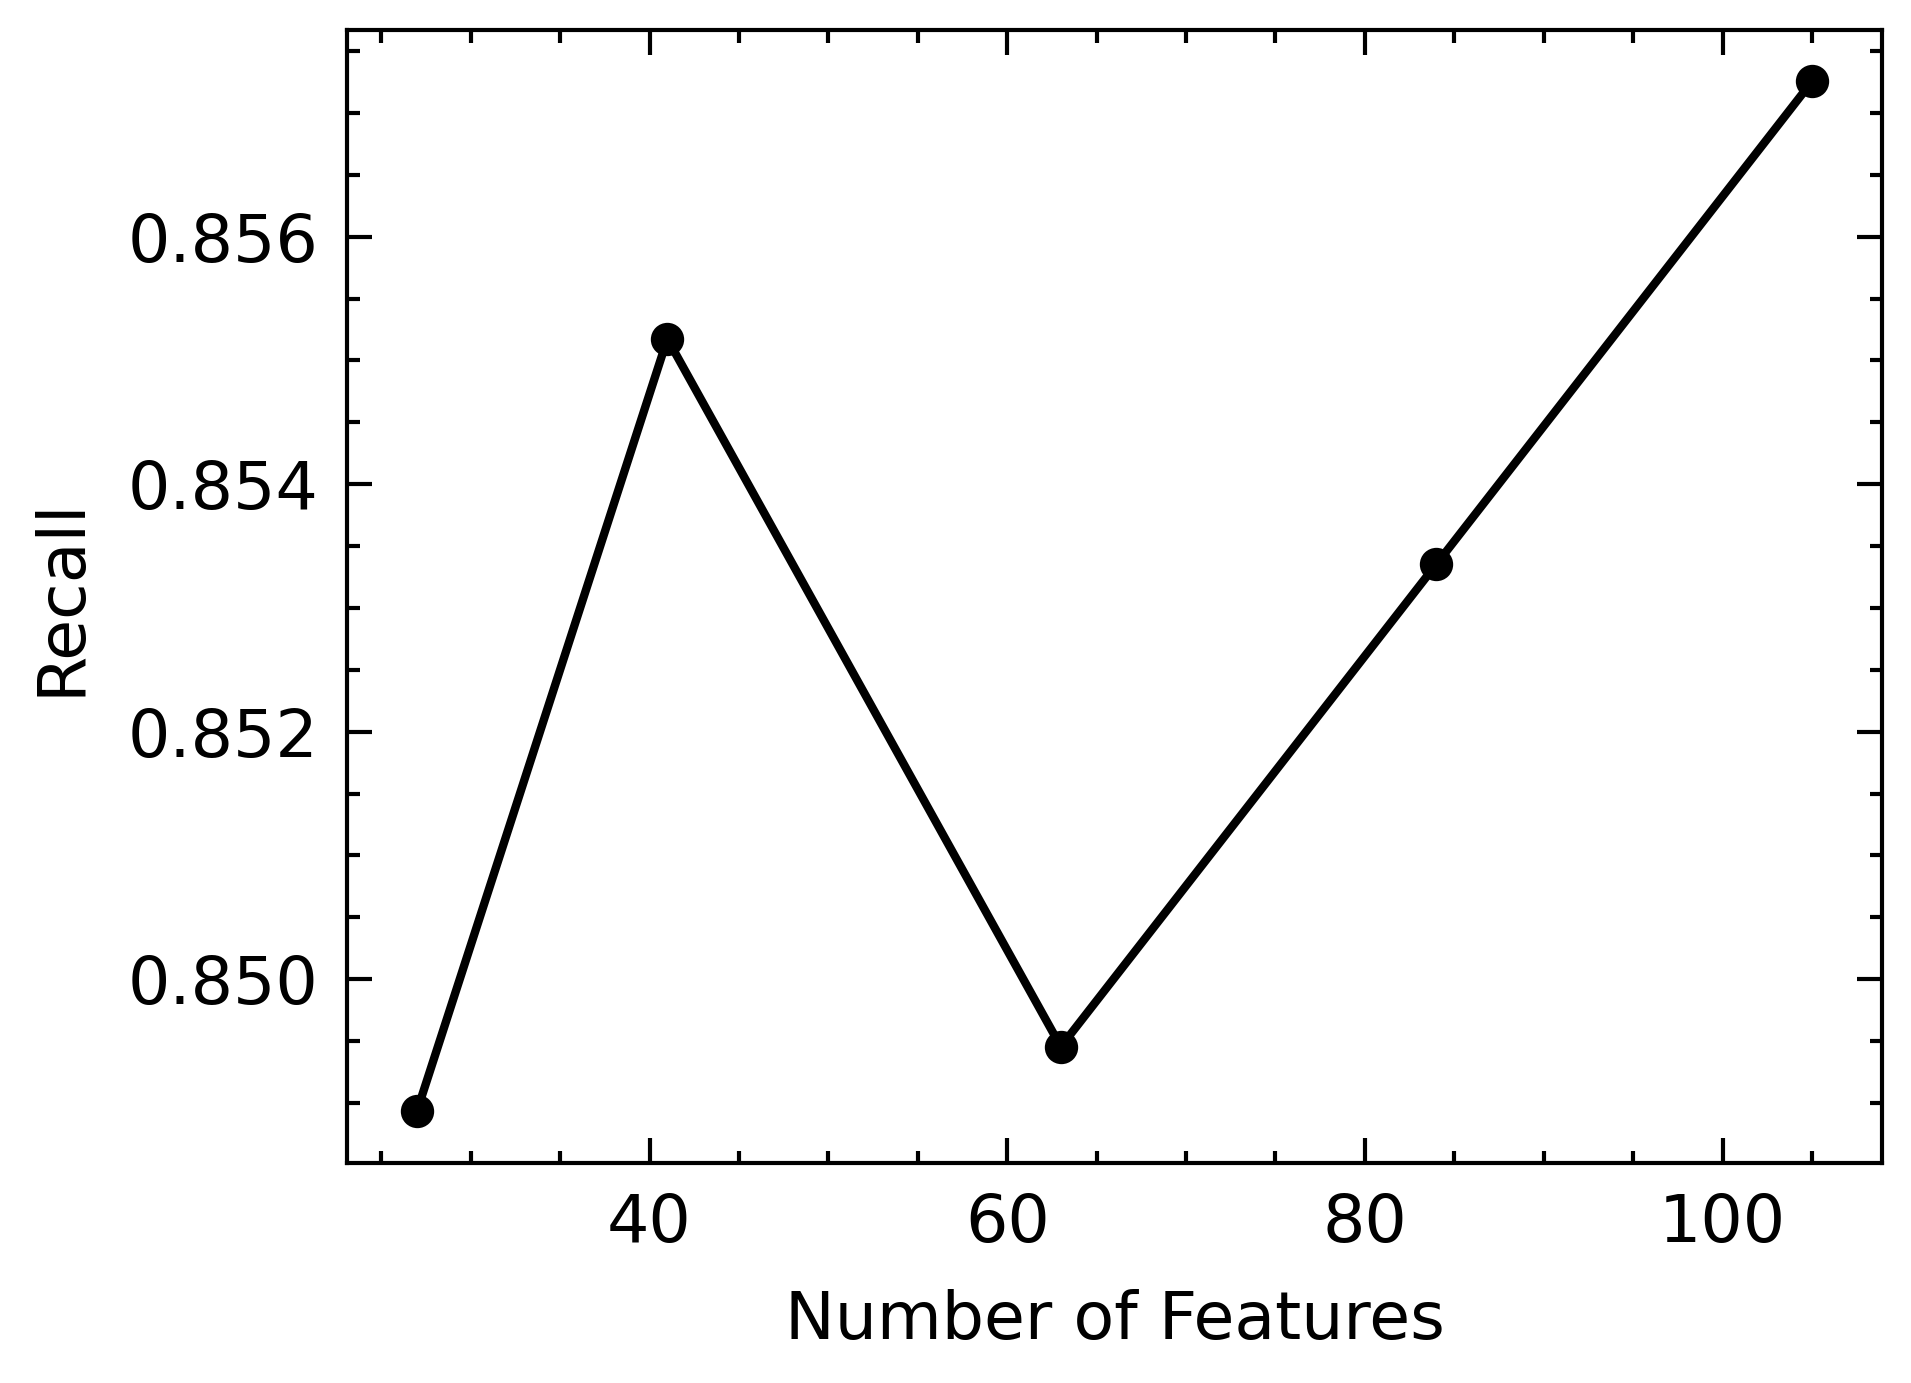

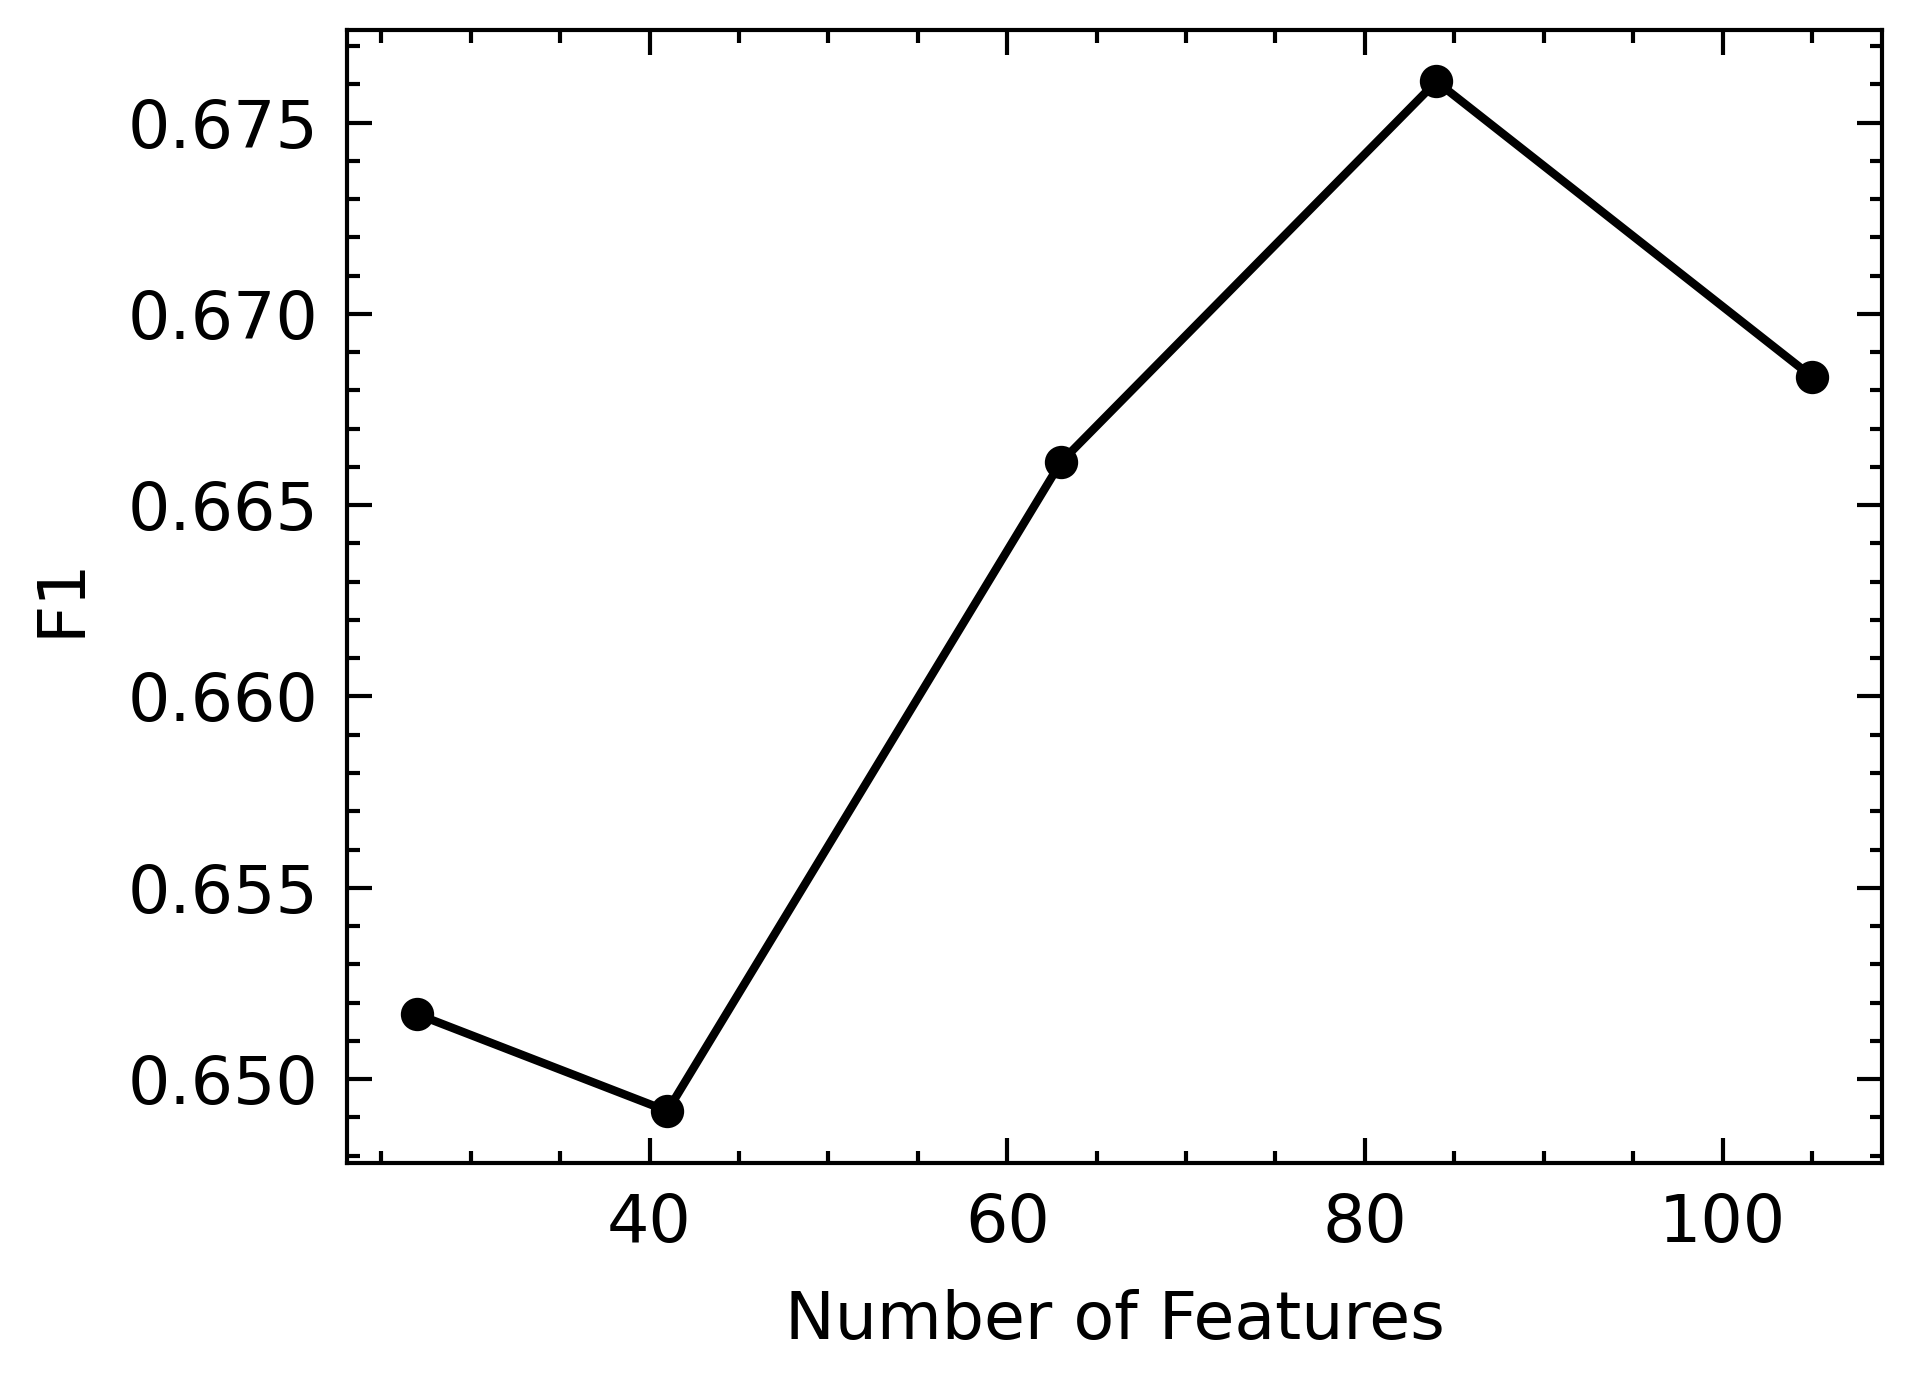

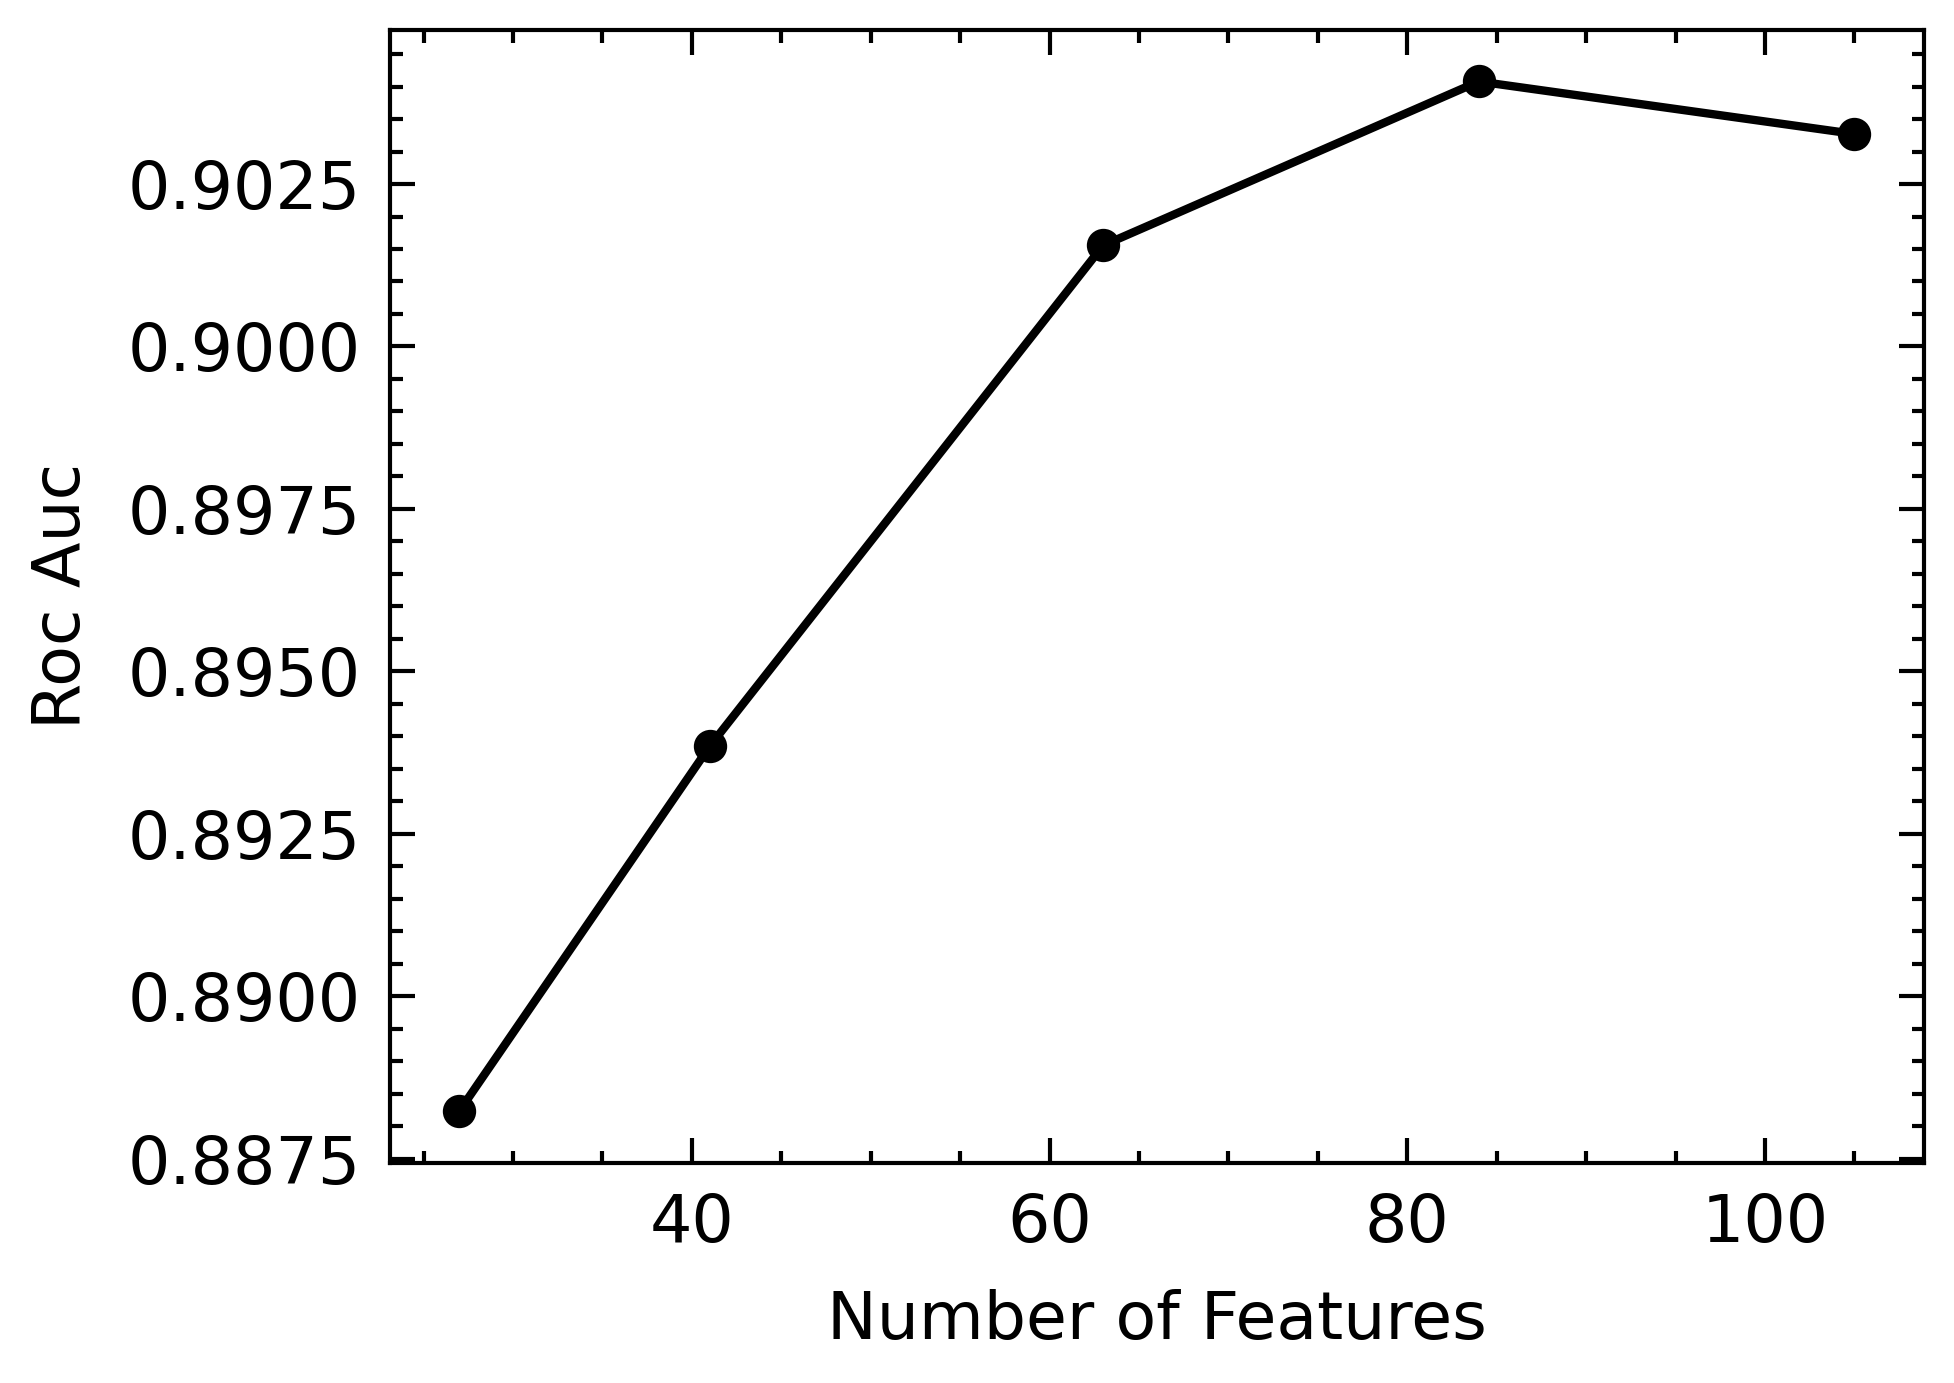

In [18]:
# plot nDims vs all metrics
for metric in metrics:
    metricPrint = metric.replace('_', ' ').title()
    fig, ax = plt.subplots()
    ax.plot(MLP.nDims, MLP['bestTest'+metric.capitalize()], 'o-', markersize=3)
    ax.set_xlabel('Number of Features')
    ax.set_ylabel(metricPrint)
    plt.savefig(f'figures/MLP/nDimsVs{metricPrint}.png', bbox_inches='tight')
    plt.show()

In [4]:
# Best estimator is second to last
bestEst = pd.read_pickle('data/MLP_results.pkl').iloc[-2].searchObj.best_estimator_
bestEst

MLPClassifier(alpha=0.05, learning_rate='adaptive', max_iter=300,
              random_state=0)

In [5]:
pd.read_pickle('data/MLP_results.pkl').iloc[-2].searchObj.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [30]:
# Load data
adult = pd.read_parquet('data/formatted_data.parquet')
adult.drop(columns=['fnlwgt', 'education-num'], inplace=True) # dropping these columns
train = adult[adult['set'] == 'train'].drop(columns=['set'])
test = adult[adult['set'] == 'test'].drop(columns=['set'])

train_ = dfCategoryLimit(train, 20) # limit categories to 20!!!
XTrain, YTrain, XTest, YTest = XYSplit(train_, test)
XTrain, YTrain = donwSampleLabels(XTrain, YTrain)

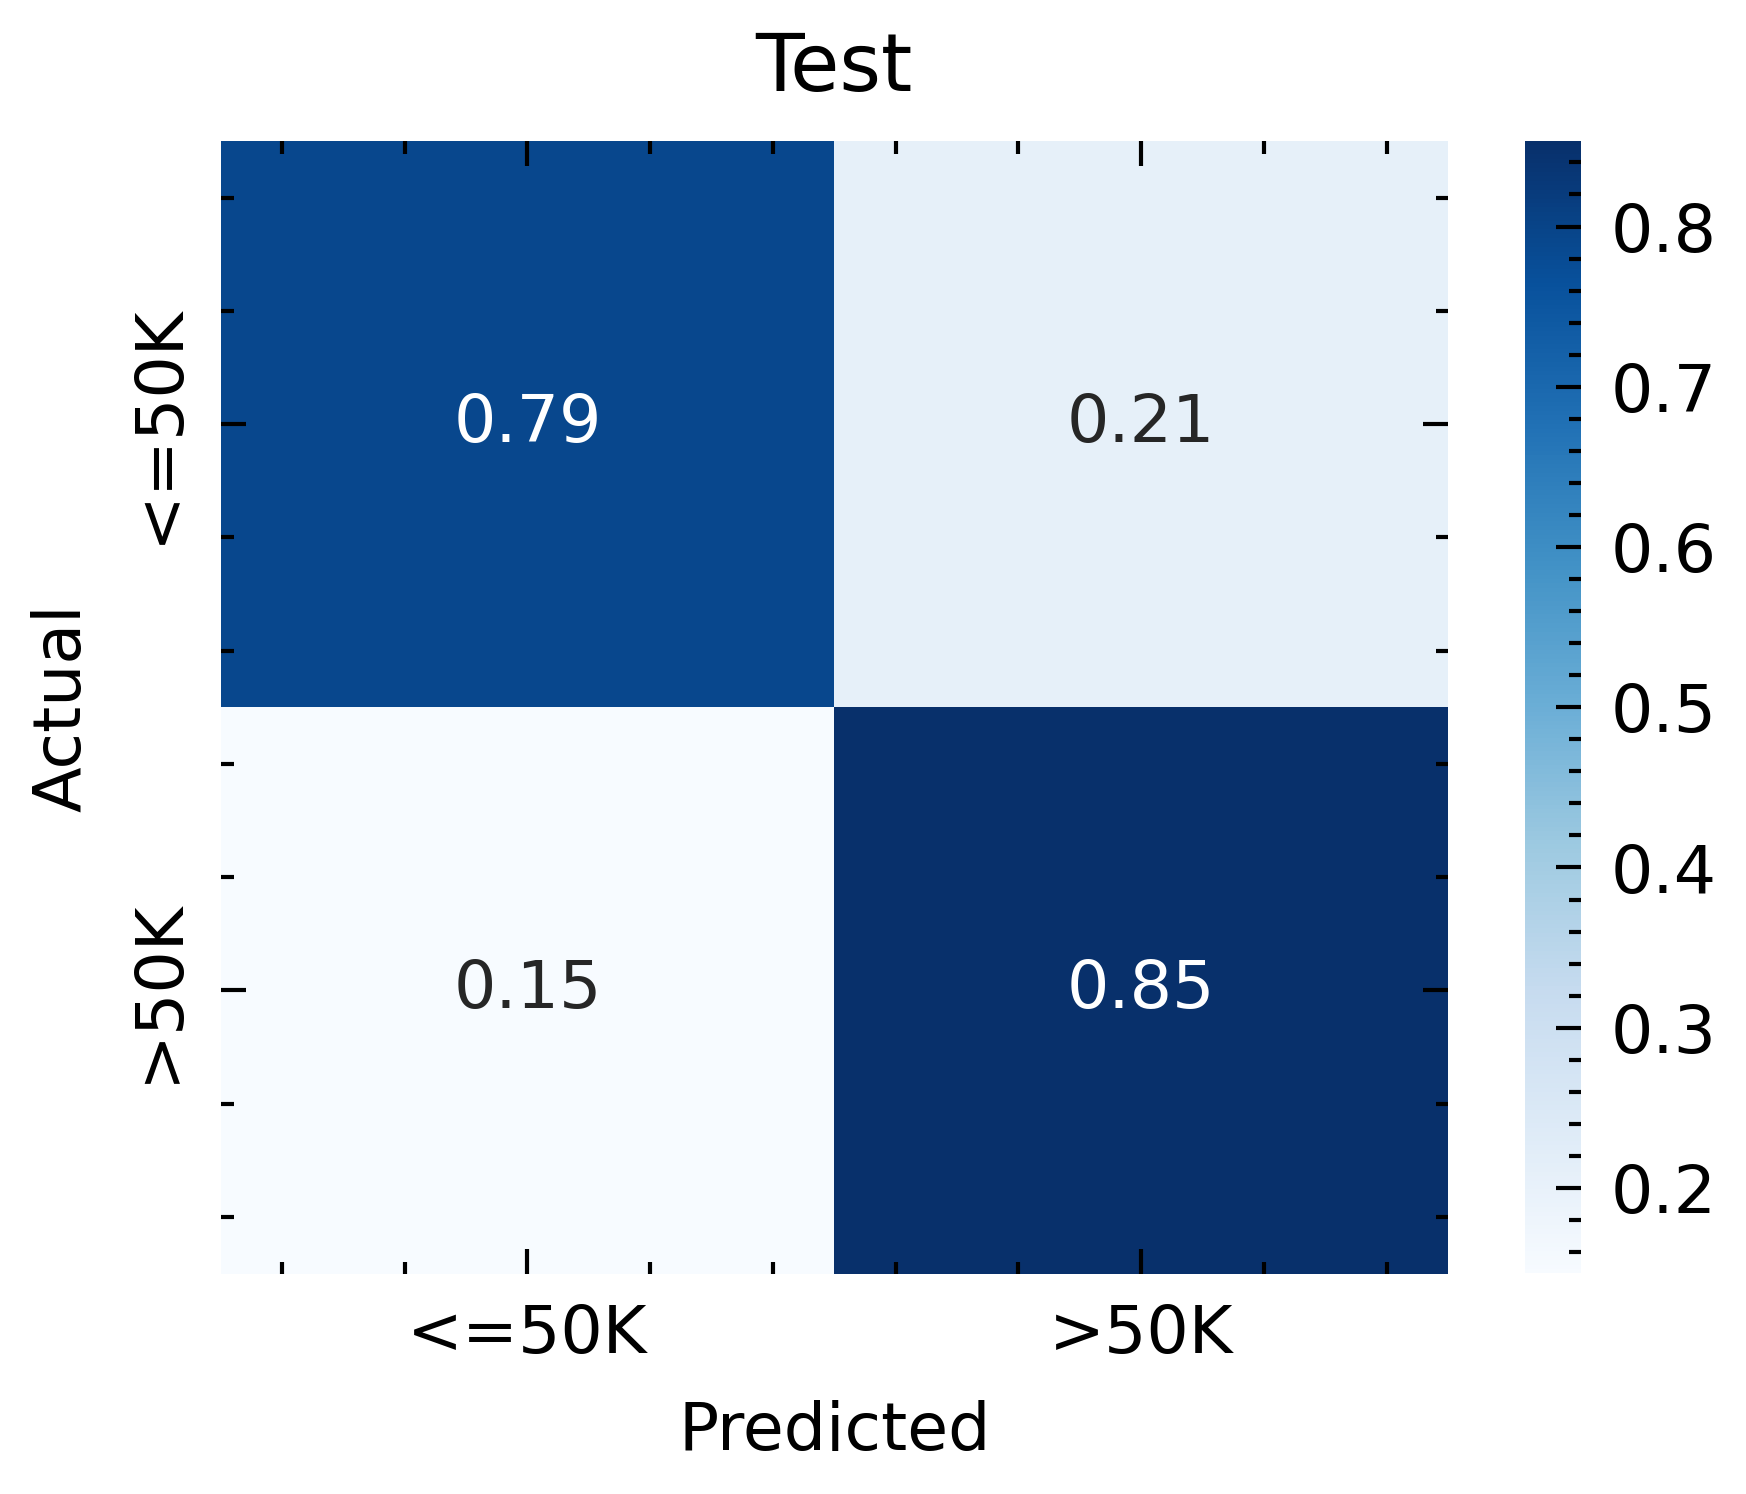

In [32]:
preprocessor = getPreprocessor().fit(XTrain) # fit the preprocessor
XTrainTrans = preprocessor.transform(XTrain) # transform the training data
XTestTrans = preprocessor.transform(XTest) # transform the test data

YTestPred = bestEst.predict(XTestTrans)
YTrainPred = bestEst.predict(XTrainTrans)

# plot the confusion matrix
plotConfusionMatrix(YTest, YTestPred, labels=['<=50K', '>50K'], title='Test', savePath='figures/MLP/TestConfusionMatrix.png')

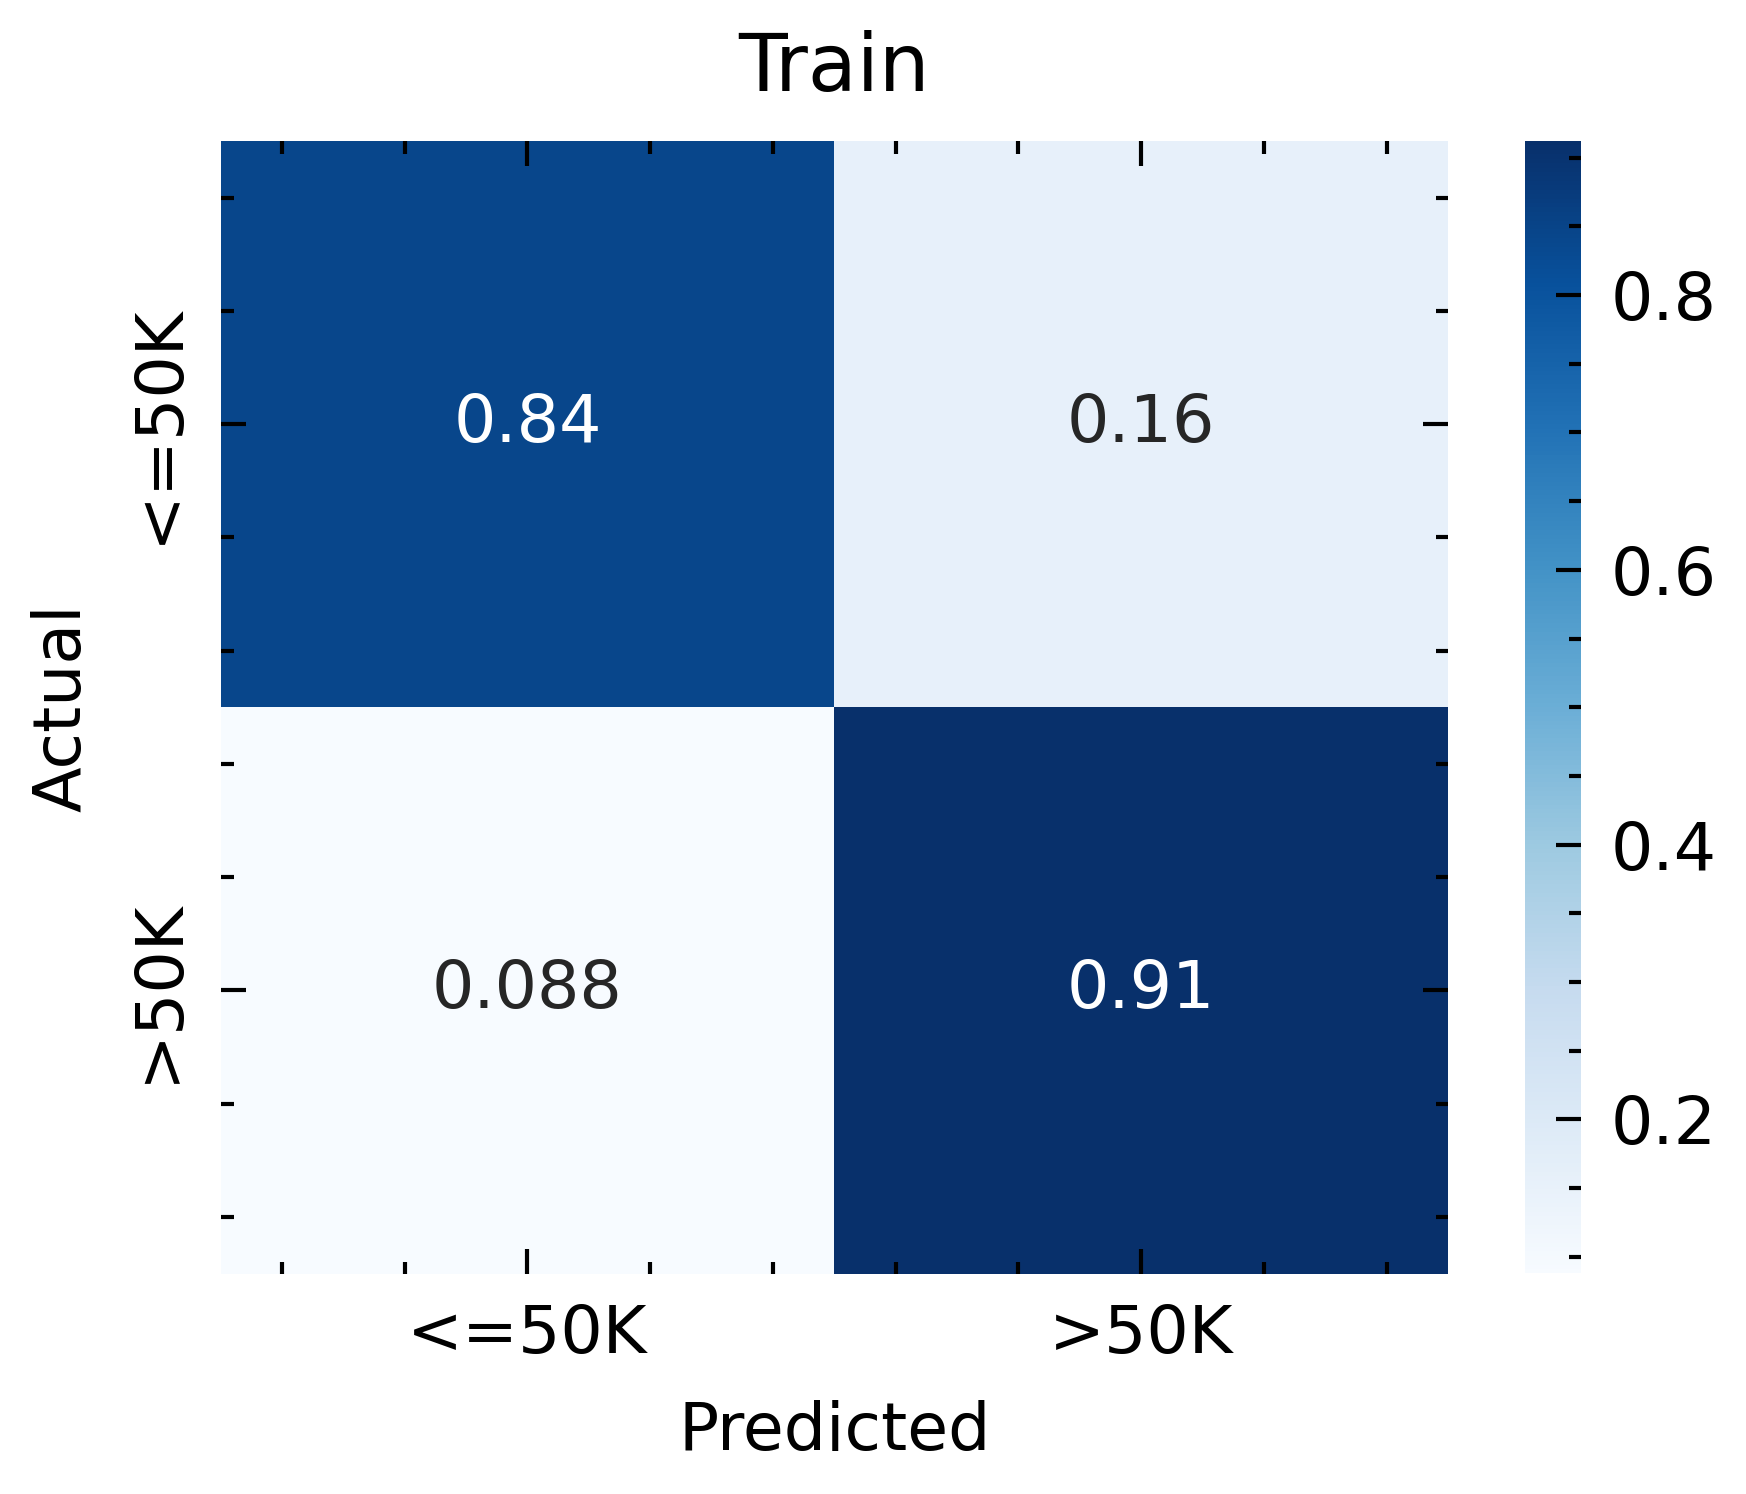

In [33]:
plotConfusionMatrix(YTrain, YTrainPred, labels=['<=50K', '>50K'], title='Train', savePath='figures/MLP/TrainConfusionMatrix.png')

In [36]:
bestResults = pd.DataFrame(pd.read_pickle('data/MLP_results.pkl').iloc[-2].cvResults)
bestResults = bestResults[['param_alpha', 'param_hidden_layer_sizes', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision', 'mean_test_roc_auc']]
bestResults

,param_alpha,param_hidden_layer_sizes,mean_test_recall,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_roc_auc
0,0.0001,"(64, 32, 16)",0.822473,0.787400,0.794385,0.769361,0.856795
1,0.0001,"(100,)",0.816350,0.807805,0.809255,0.802917,0.889863
2,0.05,"(64, 32, 16)",0.820300,0.794223,0.799242,0.780700,0.870812
3,0.05,"(100,)",0.841216,0.819793,0.823319,0.807342,0.904218


In [45]:
stats = bestResults.groupby(['param_alpha', 'param_hidden_layer_sizes']).mean().sort_index()
stats.to_pickle('data/MLP_stats.pkl')
stats

mean_test_recall  mean_test_accuracy  \
param_alpha param_hidden_layer_sizes                                         
0.0001      (64, 32, 16)                      0.822473            0.787400   
            (100,)                            0.816350            0.807805   
0.0500      (64, 32, 16)                      0.820300            0.794223   
            (100,)                            0.841216            0.819793   

                                      mean_test_f1  mean_test_precision  \
param_alpha param_hidden_layer_sizes                                      
0.0001      (64, 32, 16)                  0.794385             0.769361   
            (100,)                        0.809255             0.802917   
0.0500      (64, 32, 16)                  0.799242             0.780700   
            (100,)                        0.823319             0.807342   

                                      mean_test_roc_auc  
param_alpha param_hidden_layer_sizes                     
0.0001      (64, 32, 16)                       0.856795  
            (100,)                             0.889863  
0.0500      (64, 32, 16)                       0.870812  
            (100,)                             0.904218

In [46]:
pd.read_pickle('data/MLP_stats.pkl')

mean_test_recall  mean_test_accuracy  \
param_alpha param_hidden_layer_sizes                                         
0.0001      (64, 32, 16)                      0.822473            0.787400   
            (100,)                            0.816350            0.807805   
0.0500      (64, 32, 16)                      0.820300            0.794223   
            (100,)                            0.841216            0.819793   

                                      mean_test_f1  mean_test_precision  \
param_alpha param_hidden_layer_sizes                                      
0.0001      (64, 32, 16)                  0.794385             0.769361   
            (100,)                        0.809255             0.802917   
0.0500      (64, 32, 16)                  0.799242             0.780700   
            (100,)                        0.823319             0.807342   

                                      mean_test_roc_auc  
param_alpha param_hidden_layer_sizes                     
0.0001      (64, 32, 16)                       0.856795  
            (100,)                             0.889863  
0.0500      (64, 32, 16)                       0.870812  
            (100,)                             0.904218